In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


1. IMPORT DATASET FROM CSV

In [3]:
# file path
csv_path = "../dataset/TAIPEI_diabetes.csv" 

# create dataframe to start exploring
diabete_df = pd.read_csv(csv_path)

# check if the dataset is correctly created
diabete_df

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0
...,...,...,...,...,...,...,...,...,...,...
14995,1490300,10,65,60,46,177,33.512468,0.148327,41,1
14996,1744410,2,73,66,27,168,30.132636,0.862252,38,1
14997,1742742,0,93,89,43,57,18.690683,0.427049,24,0
14998,1099353,0,132,98,18,161,19.791645,0.302257,23,0


---
* The dataset contain 15000 rows & 10 columns
---

2. CHECK MISSING VALUE

In [4]:
# generates statistics summary
diabete_df.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.502922e+06,3.224533,107.856867,71.220667,28.814000,137.852133,31.509646,0.398968,30.137733,0.333333
std,2.892534e+05,3.391020,31.981975,16.758716,14.555716,133.068252,9.759000,0.377944,12.089703,0.471420
min,1.000038e+06,0.000000,44.000000,24.000000,7.000000,14.000000,18.200512,0.078044,21.000000,0.000000
25%,1.252866e+06,0.000000,84.000000,58.000000,15.000000,39.000000,21.259887,0.137743,22.000000,0.000000
50%,1.505508e+06,2.000000,104.000000,72.000000,31.000000,83.000000,31.767940,0.200297,24.000000,0.000000
75%,1.755205e+06,6.000000,129.000000,85.000000,41.000000,195.000000,39.259692,0.616285,35.000000,1.000000
max,1.999997e+06,14.000000,192.000000,117.000000,93.000000,799.000000,56.034628,2.301594,77.000000,1.000000


---
* Count: We have 15000 Patient and all the information for those patients. So we can conclude that we have no missing value
* Mean: <br>
    in the last column (Diabetic)  we can deduce that we have 1/3 (33%) of patient which are diabetic. this population in this dataset, leaving with diabete seems above the world satistic (about 269 million on 4 billion ~ 6.57% ) <br> 
    (PlasmaGlucose) Les valeurs de glycémie de base (cad à Jeun) ne sont pas communiquées dans ce dataset. Par contre nous avons les valeurs après ingestion de la solution de glucose qui nous donne concentration de glucose dans le plasma <br> 
        Valeurs normales du glucose plasmatique apres 2 heures <br>
        1. < 140 mg/dL (7.8 mmol/L) → Normal <br>
        2. 140 - 199 mg/dL (7.8 - 11.0 mmol/L) → Intolérance au glucose (prédiabète) <br>
        3. ≥ 200 mg/dL (11.1 mmol/L) → Diabète <br>
<br>
        Ce test est souvent utilisé pour diagnostiquer : <br>
            ✅ Le diabète de type 2  <br>
            ✅ Le diabète gestationnel (chez les femmes enceintes) <br>



    Age : la moyenne d'age est 30 ans par contre la médiane (cad 50%) est de 24. Ce qui signifierai que dans le set de donnée il y a peu de personnes interrogées qui ont un âge senior (soit environ 25% du dataset)



---

In [5]:
# vérifier que les personnes qui ont un seuil de PlasmaGlucose > 140 sont toutes diabetiques vous vérifier si c'est sur cette seule donnée que le diagnostique a été établi. ==> Ce n'est pas le cas après vérification

resultat_Diabete_Plasma = diabete_df[diabete_df['PlasmaGlucose'] > 140.0]          # resultat = diabete_df[diabete_df['PlasmaGlucose'] > 140.0]['Diabetic']
resultat_Diabete_Plasma

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
14,1683688,0,148,58,11,179,39.192076,0.160829,45,0
17,1485251,1,156,53,15,226,29.786192,0.203824,41,1
27,1398321,3,163,87,42,428,18.571188,0.777016,25,0
31,1117458,8,152,83,42,46,18.909545,0.602582,34,0
...,...,...,...,...,...,...,...,...,...,...
14957,1582615,0,156,57,35,38,21.473855,0.127779,25,0
14961,1808006,0,153,49,17,23,37.888759,0.145602,21,0
14963,1916034,6,147,89,43,17,38.549360,0.284416,23,0
14974,1752911,9,169,93,40,58,21.856319,0.792317,55,1


In [6]:
# vérifier que les personnes qui ont un seuil de PlasmaGlucose < 140 sont toutes non diabetiques vous vérifier si c'est sur cette seule donnée que le diagnostique a été établi. ==> 

resultat_nonDiabete_Plasma = diabete_df[diabete_df['PlasmaGlucose'] < 140.0]          # resultat = diabete_df[diabete_df['PlasmaGlucose'] > 140.0]['Diabetic']
resultat_nonDiabete_Plasma

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0
5,1619297,0,82,92,9,253,19.724160,0.103424,26,0
...,...,...,...,...,...,...,...,...,...,...
14995,1490300,10,65,60,46,177,33.512468,0.148327,41,1
14996,1744410,2,73,66,27,168,30.132636,0.862252,38,1
14997,1742742,0,93,89,43,57,18.690683,0.427049,24,0
14998,1099353,0,132,98,18,161,19.791645,0.302257,23,0


In [7]:
# Vérifier les dépendances des mesures médicales dans l'apparition du diabete  ==> Il y a un lien plus fort entre le vieillissement (Age) et l'apparition de Diabete et aussi entre le nombre de Grossesse et l'apparition du Diabete
# les mesures sont très peu correlées entre elles ==> donc on peut déduire que l'ensemble des colonne speuvent être utiles dans notre ML
# correlation entre l'age et la grossesse ==> laquelle des 2 est predominante dans l'apparition du diabete?

correlation = diabete_df.corr()
correlation

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
PatientID,1.000000,0.006774,-0.001858,0.008746,-0.002406,-0.020698,-0.003156,-0.015413,-0.007096,-0.012494
Pregnancies,0.006774,1.000000,0.054502,0.043528,0.063605,0.104487,0.086386,0.054240,0.136972,0.407315
PlasmaGlucose,-0.001858,0.054502,1.000000,0.007212,0.027100,0.033545,0.020653,0.009057,0.038864,0.128004
DiastolicBloodPressure,0.008746,0.043528,0.007212,1.000000,0.011106,0.022649,0.015873,0.014099,0.041333,0.091307
TricepsThickness,-0.002406,0.063605,0.027100,0.011106,1.000000,0.029688,0.024745,-0.000951,0.061383,0.152505
SerumInsulin,-0.020698,0.104487,0.033545,0.022649,0.029688,1.000000,0.051223,0.046324,0.088007,0.247375
BMI,-0.003156,0.086386,0.020653,0.015873,0.024745,0.051223,1.000000,0.028868,0.062910,0.210508
DiabetesPedigree,-0.015413,0.054240,0.009057,0.014099,-0.000951,0.046324,0.028868,1.000000,0.055633,0.170302
Age,-0.007096,0.136972,0.038864,0.041333,0.061383,0.088007,0.062910,0.055633,1.000000,0.342605
Diabetic,-0.012494,0.407315,0.128004,0.091307,0.152505,0.247375,0.210508,0.170302,0.342605,1.000000


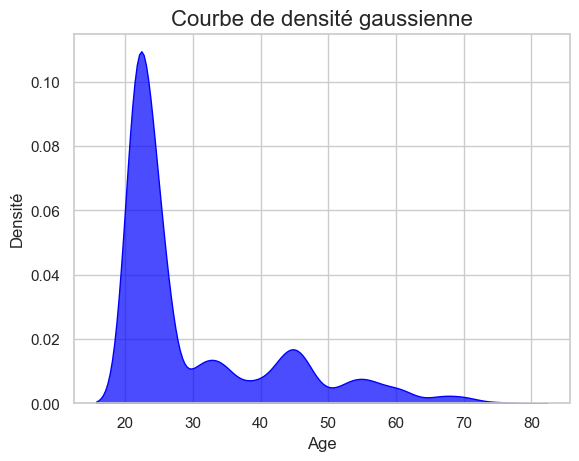

In [ ]:
# objectif: focus sur l'age pour voir comment le set est construit. on peut constater que la grande majorité des données prélevées ce sont faites sur la tranche d'age de 20 à 3O ans


sns.set(style="whitegrid")
sns.kdeplot(diabete_df['Age'], fill=True, color="blue", alpha=0.7)

# Ajouter un titre et des labels
plt.title("Courbe de densité gaussienne", fontsize=16)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Densité", fontsize=12)

# Afficher le graphique
plt.show()

In [19]:
age_jeune = diabete_df[diabete_df['Age'] <= 30.0]          # resultat = diabete_df[diabete_df['PlasmaGlucose'] > 140.0]['Diabetic']
age_jeune.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.028000e+04,10280.000000,10280.000000,10280.000000,10280.000000,10280.000000,10280.000000,10280.000000,10280.000000,10280.000000
mean,1.505905e+06,2.884533,107.007004,70.764008,28.221109,128.703307,31.087245,0.382357,23.026751,0.213813
std,2.887257e+05,3.340430,31.923231,17.155644,14.408405,127.747449,9.935371,0.363318,1.960443,0.410016
min,1.000038e+06,0.000000,44.000000,24.000000,7.000000,14.000000,18.200512,0.078044,21.000000,0.000000
25%,1.256762e+06,0.000000,83.000000,56.000000,14.000000,36.000000,21.009703,0.137152,22.000000,0.000000
50%,1.512156e+06,1.000000,103.000000,71.000000,31.000000,75.000000,31.415300,0.198007,23.000000,0.000000
75%,1.757497e+06,6.000000,129.000000,85.000000,41.000000,186.000000,39.282682,0.582326,24.000000,0.000000
max,1.999997e+06,14.000000,191.000000,117.000000,93.000000,799.000000,55.858813,2.287388,30.000000,1.000000


In [21]:
age_jeune2 = diabete_df[diabete_df['Age'] <= 40.0]
age_jeune2 = age_jeune2[age_jeune2['Age'] > 30]          # resultat = diabete_df[diabete_df['PlasmaGlucose'] > 140.0]['Diabetic']
age_jeune2.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.554000e+03,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000
mean,1.489666e+06,3.415701,107.510296,71.598456,28.859717,149.675032,31.438612,0.418376,34.622909,0.396396
std,2.938973e+05,3.406317,31.728609,16.149763,14.374519,138.063562,9.628813,0.386036,2.741612,0.489306
min,1.000069e+06,0.000000,44.000000,25.000000,7.000000,14.000000,18.209769,0.078056,31.000000,0.000000
25%,1.226616e+06,0.000000,85.000000,59.000000,15.000000,42.000000,21.221074,0.139185,32.000000,0.000000
50%,1.481806e+06,2.000000,105.000000,73.000000,30.000000,92.000000,31.712477,0.211743,34.000000,0.000000
75%,1.745893e+06,6.000000,127.000000,85.000000,41.750000,211.000000,38.826900,0.664129,37.000000,1.000000
max,1.999232e+06,14.000000,192.000000,114.000000,89.000000,713.000000,55.906470,2.267550,40.000000,1.000000
